In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from skimage.transform import iradon
import math
import numpy as np
import Methods as m
import importlib
importlib.reload(m)

<module 'Methods' from '/Users/markzhitnitsky/Desktop/School/2025-26 Year/PHYS409/Experiment 1 - PET/Code/Methods.py'>

In [81]:
directory = "./data/Measurement Run 5 2026-01-16"
countArr, uCountArr, distance, angles = m.readSinogram(directory)
recon = iradon(countArr, theta=angles, output_size=int(len(distance) * np.sqrt(2)), filter_name="cosine", circle=False)

# print(recon.shape)
dimx, dimy = recon.shape # dims are the same since it has to be square
total_physical_width = dimx * (distance[1]- distance[0])
# print(total_physical_width)
half_width = total_physical_width / 2
recon_distance = np.linspace(-half_width, half_width, dimx)
# print(recon_distance)

In [82]:
# print(countArr.size)
# print(uCountArr.size)
# print(distance.size)
# print(angles.size)
# print(recon.size)

In [83]:
# Assuming 'recon' is your 2D data and 'sigma_recon' is your 2D uncertainty
x, y = np.meshgrid(recon_distance, recon_distance)
# print(x)
# print(y)

# Flatten everything
position = np.vstack((x.ravel(), y.ravel()))
# print(position)
# print(position.shape)
ydata = recon.ravel()
# yerr = uCountArr.ravel()

# Initial guesses are CRITICAL for double Gaussians (find peaks manually or use max)
# [a1, x1, y1, sx1, sy1, a2, x2, y2, sx2, sy2, offset]
initial_guess = [1000, 0, 5, 2, 2, 1000, 0, -5, 2, 2, 0]

popt, pcov = curve_fit(m.double_gaussian_2d, position, ydata, p0=initial_guess)


[38.14836012 -0.19945204  5.37087985  0.67327028  0.71325002 37.35668735
 -1.2436669  -5.43409756  0.67673877  0.71539712  2.14794972]
r1 = 0.98083 +/- 0.00003
r2 = 0.98477 +/- 0.00003


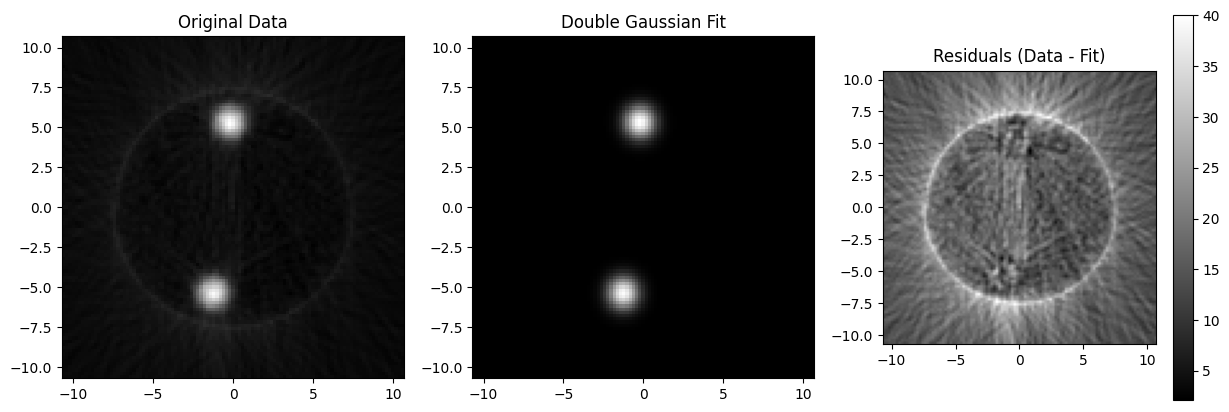

In [93]:
# 1. Use popt to generate the fitted data
# We reuse the xdata (flattened meshgrid) from the fit
y_fit_flat = m.double_gaussian_2d(position, *popt)
# a1, x1, y1, sx1, sy1, a2, x2, y2, sx2, sy2, offset = popt
# print(popt)
sx1 = popt[3]
sy1 = popt[4]
sx2 = popt[8]
sy2 = popt[9]
usx1 = pcov[3][3]
usy1 = pcov[4][4]
usx2 = pcov[8][8]
usy2 = pcov[9][9]

r1 = np.sqrt(sx1**2 + sy1**2)
r2 = np.sqrt(sx2**2 + sy2**2)
ur1 = r1 * np.sqrt(usx1**2 * 2 + usy1**2 * 2)
ur2 = r2 * np.sqrt(usx2**2 * 2 + usy2**2 * 2)

if ur2 > 0:
    precision2 = -int(math.floor(math.log10(abs(ur2))))
else:
    precision2 = 2 # Default fallback

if ur1 > 0:
    precision1 = -int(math.floor(math.log10(abs(ur1))))
else:
    precision1 = 2 # Default fallback

print(f"r1 = {r1:.{precision1}f} +/- {ur1:.{precision1}f}")
print(f"r2 = {r2:.{precision2}f} +/- {ur2:.{precision2}f}")

# 2. Reshape it back to the original 2D dimensions
# ny, nx were defined during your meshgrid creation
fit_image = y_fit_flat.reshape(recon_distance.size, recon_distance.size)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot Original Data
im0 = ax[0].imshow(recon, origin="lower",extent=[
            recon_distance[0], recon_distance[-1],
            recon_distance[0], recon_distance[-1]],
        cmap="gray")
ax[0].set_title("Original Data")

# Plot the Fit
im1 = ax[1].imshow(fit_image, origin="lower", extent=[
            recon_distance[0], recon_distance[-1],
            recon_distance[0], recon_distance[-1]],
        cmap="gray")
ax[1].set_title("Double Gaussian Fit")

# Plot Residuals (Data - Fit)
# If the fit is good, this should look like random noise
im2 = ax[2].imshow(recon - fit_image, origin="lower", cmap='gray', extent=[
            recon_distance[0], recon_distance[-1],
            recon_distance[0], recon_distance[-1]])
ax[2].set_title("Residuals (Data - Fit)")

plt.colorbar(im1, ax=ax[2])
plt.savefig("figures/Double 2D Gaussian Fit of image reconstruction")
plt.show()

### Plot Gaussian on scans

In [70]:
dist_array, counts_array, ucounts_array = m.readLineScan("./data/Resolution Measurements - 2026-01-16/Jan 16, 2026, 2_22 PM, Scan1, 0_0 Deg, w_2mm.dat")
# m.plotLineScan(dist_array, counts_array, ucounts_array, "Wide LineScan for W=8mm")
x = dist_array
y = counts_array

p0 = [max(y), x[(x.size // 2)], 1.0, np.min(y)]

# 4. Perform the weighted fit
popt, pcov = curve_fit(m.gaussian_1d, dist_array, counts_array, p0=p0, sigma=ucounts_array)
# fitted_curve = m.gaussian_1d(dist_array, *popt)
# amp_f, mean_f, sigma_f, offset_f = popt
# uamp_f, umean_f, usigma_f, uoffset_f = np.sqrt(pcov)

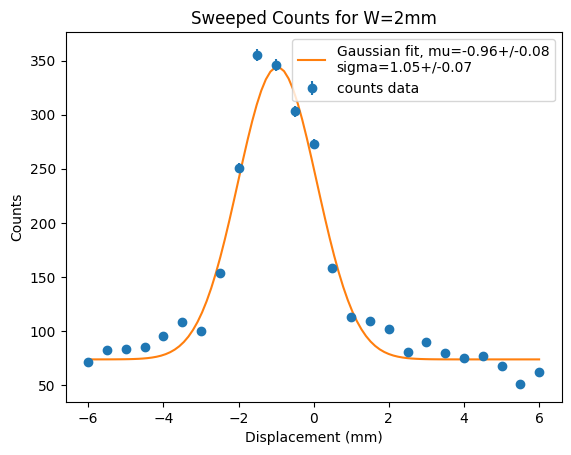

In [79]:
m.plotWidthScanGaussian(dist_array, counts_array, ucounts_array, 2, popt, pcov, "Gaussian fit to w=2mm linescane")
# plt.errorbar(dist_array, counts_array, fmt='-o', yerr = counts_uncertainty, label=f"counts for width = {2}mm")

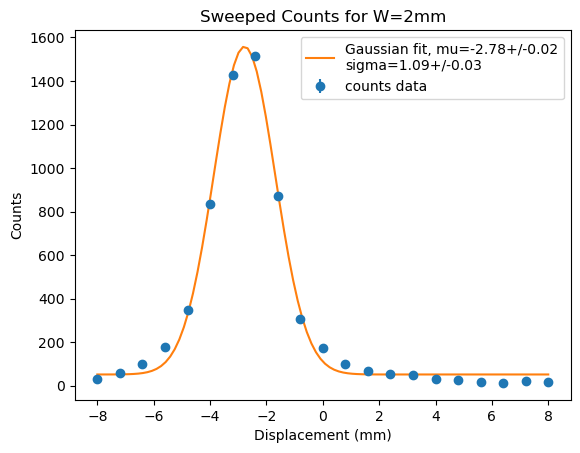

In [18]:
dist_array, counts_array, ucounts_array = m.readLineScan("./data/Width calibration - 2026-01-23/Jan 23, 2026, 3_01 PM, Scan1, 0_0 Deg, w-3mm.dat")
x = dist_array
y = counts_array

# amplitude, x0, sigma_x, offset
p0 = [max(y), x[np.argmax(y)], 1.0, np.min(y)]

popt, pcov = curve_fit(m.gaussian_1d, dist_array, counts_array, p0=p0)
m.plotWidthScanGaussian(dist_array, counts_array, ucounts_array, 2, popt, pcov, "Gaussian fit to w=3mm linescan")